In [1]:
from pathlib import Path
from kedro.framework.context import load_context

current_dir = Path.cwd()
proj_path = current_dir.parent
context = load_context(proj_path)

c:\users\valxa\anaconda3\envs\splatoon-ml\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [3]:
import codecs

df_train = catalog.load("train")
df_test = catalog.load("test")
df_stage = catalog.load("stagedata")
df_weapon = catalog.load("weapon")


2020-09-21 12:54:02,982 - kedro.io.data_catalog - INFO - Loading data from `train` (CSVDataSet)...
2020-09-21 12:54:03,170 - kedro.io.data_catalog - INFO - Loading data from `test` (CSVDataSet)...


c:\users\valxa\anaconda3\envs\splatoon-ml\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2020-09-21 12:54:03,258 - kedro.io.data_catalog - INFO - Loading data from `stagedata` (CSVDataSet)...
2020-09-21 12:54:03,260 - kedro.io.data_catalog - INFO - Loading data from `weapon` (CSVDataSet)...


In [4]:
cat_features = [
    "period", "game-ver", "lobby-mode", "lobby", "mode", "stage", "A1-weapon",
    "A2-weapon", "A3-weapon", "A4-weapon", "B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon",
    "A1-rank", "A2-rank", "A3-rank", "A4-rank", "B1-rank", "B2-rank", "B3-rank", "B4-rank", 
]
num_features = [
    "A1-level", "A2-level", "A3-level", "A4-level",
    "B1-level", "B2-level", "B3-level", "B4-level"
]
target_col = "y"
target_id = "id"
players = ["A1", "A2", "A3", "A4", "B1", "B2", "B3", "B4"]

In [5]:
cat_features.remove("period")
cat_features.remove("lobby")
cat_features.remove("game-ver")
data = pd.concat([df_train.drop([target_id, target_col], axis=1), df_test.drop([target_id], axis=1)])
data = data.drop(["period", "lobby", "game-ver"], axis=1)
y = torch.tensor(df_train[target_col].values).flatten()
test_id = df_test[target_id]

In [6]:
df_weapon["category"] = df_weapon["category1"] + df_weapon["category2"]
df_weapon = df_weapon.drop(["category1", "category2"], axis=1)

In [7]:
weapons = [p + "-weapon" for p in players]
for player in players:
    data[f"{player}-rank"] = data[f"{player}-rank"].fillna("-1")
    data[f"{player}-weapon"] = data[f"{player}-weapon"].fillna(data[f"{player}-weapon"].value_counts().index[0])
    data[f"{player}-level"] = data[f"{player}-level"].fillna("-1")

In [9]:
for weapon in weapons:
    temp_weapon_detail = data[[weapon]].join(df_weapon.set_index("key"), on=weapon)
    weapon_detail = [weapon[:3] + col for col in temp_weapon_detail.columns]
    cat_features.extend(weapon_detail)
    temp_weapon_detail.columns = weapon_detail
    data = pd.concat([data, temp_weapon_detail], axis=1)
    data = data.drop(weapon, axis=1)
    cat_features.remove(weapon)    

In [11]:
cat_szs = []
for cat in cat_features:
    data[cat] = data[cat].astype('category')
    cat_szs.append(len(data[cat].cat.categories))
    data[cat] = data[cat].cat.codes.values
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]

In [12]:
X = data[:len(df_train.index)]
X_test = data[len(df_train.index):]

nums = np.stack([X[col].astype(np.float16).values for col in num_features], 1)
nums = torch.tensor(nums, dtype=torch.float)
cats = np.stack([X[col].values for col in cat_features], 1)
cats = torch.tensor(cats, dtype=torch.int64)
print(f"nums shape: {nums.shape}")
print(f"cats shape: {cats.shape}")
nums_test = np.stack([X_test[col].astype(np.float16).values for col in num_features], 1)
nums_test = torch.tensor(nums_test, dtype=torch.float)
cats_test = np.stack([X_test[col].values for col in cat_features], 1)
cats_test = torch.tensor(cats_test, dtype=torch.int64)

nums shape: torch.Size([66125, 8])
cats shape: torch.Size([66125, 59])


In [13]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x


In [15]:
torch.manual_seed(33)
model = TabularModel(emb_szs, nums.shape[1], 2, [200,100], p=0.3)
# print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


kf = KFold(n_splits=4, shuffle=True, random_state=42)

cat_train: 49593, cat_valid 16532, num_train 49593, num_valid 16532
y_train: 49593, y_valid: 16532
epoch:   1  loss: 0.66131860
epoch:   1  valid loss: 0.66395617
epoch:  10  loss: 0.65016061

Duration: 39 seconds
CE Loss: 0.66376066
accuracy: 0.59756835
cat_train: 49594, cat_valid 16531, num_train 49594, num_valid 16531
y_train: 49594, y_valid: 16531
epoch:   1  loss: 0.65396261
epoch:   1  valid loss: 0.65101975
epoch:  10  loss: 0.63852429

Duration: 39 seconds
CE Loss: 0.64999503
accuracy: 0.61805093
cat_train: 49594, cat_valid 16531, num_train 49594, num_valid 16531
y_train: 49594, y_valid: 16531
epoch:   1  loss: 0.64590925
epoch:   1  valid loss: 0.63133746
epoch:  10  loss: 0.63158184

Duration: 39 seconds
CE Loss: 0.63879758
accuracy: 0.63123828
cat_train: 49594, cat_valid 16531, num_train 49594, num_valid 16531
y_train: 49594, y_valid: 16531
epoch:   1  loss: 0.63493073
epoch:   1  valid loss: 0.61028653
epoch:  10  loss: 0.61407506

Duration: 39 seconds
CE Loss: 0.61720878
a

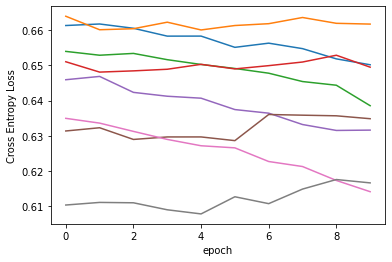

In [17]:
is_short_run = False
for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    cat_train = cats[train_index]
    cat_valid = cats[valid_index]
    num_train = nums[train_index]
    num_valid = nums[valid_index]
    y_train = y[train_index]
    y_valid = y[valid_index]
    print(f"cat_train: {len(cat_train)}, cat_valid {len(cat_valid)}, num_train {len(num_train)}, num_valid {len(num_valid)}")
    print(f"y_train: {len(y_train)}, y_valid: {len(y_valid)}")


    start_time = time.time()

    epochs = 10
    losses = []
    valid_losses = []

    for i in range(epochs):
        i+=1
        y_pred = model(cat_train, num_train)
        loss = criterion(y_pred, y_train)
        losses.append(loss)

        if i%10 == 1:
            print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_val = model(cat_valid, num_valid)
            valid_loss = criterion(y_val, y_valid)
            valid_losses.append(valid_loss)
            if i%10 == 1:
                print(f'epoch: {i:3}  valid loss: {valid_loss.item():10.8f}')

    print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

    plt.plot(range(epochs), losses)
    plt.plot(range(epochs), valid_losses)
    plt.ylabel('Cross Entropy Loss')
    plt.xlabel('epoch');

    with torch.no_grad():
        y_val = model(cat_valid, num_valid)
        accuracy = accuracy_score(np.argmax(y_val, axis=1), y_valid)
        loss = criterion(y_val, y_valid)
    print(f'CE Loss: {loss:.8f}')
    print(f'accuracy: {accuracy:.8f}')
    
    with torch.no_grad():
        y_test = np.argmax(model(cats_test, nums_test), axis=1)
    if is_short_run:
        break
    
submission_df = pd.DataFrame({target_id: test_id.values, target_col: y_test})
submission_df.to_csv("submission.csv", index=False)